# Sensitivity analysis

Tony Wong (<anthony.e.wong@colorado.edu>)

## Step 1:  Sobol'

(not covered here, leads to the `.rds` file as below)

## Step 2:  Sobol' subsample correlations

We will create sub-samples of Sobol' sensitivity runs, $X_1$, $X_2$ and $X_3$, chosen as follows:
* $X_1$ is sensitivity measure where we vary all parameters
* $X_2$ is sensitivity measure where we only vary the $T$ most sensitive parameters, and hold the other $56-T$ parameters fixed.
* $X_3$ is sensitivity measure where we keep the $T$ most sensitive parameters fixed, and vary the $56-T$ least sensitive parameters.

So, as $T$ increases, we expect to see:
* the correlation between $X_1$ and $X_2$ go to $1$, and
* the correlation between $X_1$ and $X_3$ go to $0$.
---

Navigate to Tony's local directory and read previous Sobol' sensitivity results, and load library(ies)

In [13]:
library(repr)
#setwd('/home/scrim/axw322/codes/GEOCARB/R')
setwd('/Users/tony/codes/Royer2007-Climate-Sensitivity/R')
s.out <- readRDS('../output/sobol_alpha0_NS-n40K-bs10K_25Jun2018.rds')

In practice, we will do this experiment many times and average the results.  For now, we only do it once (`n_iter`).

`n_sample` below gives the size of each sample, $X_i$ ($i=1,2,3$)

In [14]:
n_iter <- 1
n_sample <- 5000

Get the default parameter values

In [15]:
filename.calibinput <- '../input_data/GEOCARB_input_summaries_calib.csv'
source('GEOCARB-2014_parameterSetup.R')

Source the physical model

In [16]:
source('model_forMCMC.R')
source('run_geocarbF.R')

Get the data, for calculation of the Nash-Sutcliffe efficiency as sensitivity measure

In [18]:
co2_uncertainty_cutoff <- 20
source('GEOCARB-2014_getData.R')

Get the reference simulation, in case measuring sensitivity as L1 norm against this.

In [19]:
model_ref <- model_forMCMC(par_calib=par_calib0,
              par_fixed=par_fixed0,
              parnames_calib=parnames_calib,
              parnames_fixed=parnames_fixed,
              age=age,
              ageN=ageN,
              ind_const_calib=ind_const_calib,
              ind_time_calib=ind_time_calib,
              ind_const_fixed=ind_const_fixed,
              ind_time_fixed=ind_time_fixed,
              ind_expected_time=ind_expected_time,
              ind_expected_const=ind_expected_const,
              iteration_threshold=iteration_threshold)[,'co2']

`T_test` gives the number of parameters to vary, $T$.  This ranges from 2 to 55 because $T=1$ would just be a one-at-a-time sensitivity test, and because $T=56$ would be varying all of the parameters.  And the whole point is to leave some of them out.

Here, I am going by 5s for speed, but we can of course check every value of $T$.

In [20]:
#T_test <- seq(from=2, to=55, by=1)
T_test <- c(2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55)
#T_test <- seq(from=20, to=27)
nT <- length(T_test)

Initialize matrices to hold the correlations between $X_1$, $X_2$ and $X_3$.

In [24]:
corr_s12 <- mat.or.vec(n_iter, nT)
corr_s13 <- mat.or.vec(n_iter, nT)

iter <- 1  # this would be a `for` loop in the actual calculation

# x1: as-is
# sample a bunch of parameters
x1 <- s.out$pA[sample(1:nrow(s.out$pA), n_sample, replace=FALSE),]

In [28]:
model1 <- sapply(1:n_sample, function(ss) {
    model_forMCMC(par_calib=x1[ss,],
                  par_fixed=par_fixed0,
                  parnames_calib=parnames_calib,
                  parnames_fixed=parnames_fixed,
                  age=age,
                  ageN=ageN,
                  ind_const_calib=ind_const_calib,
                  ind_time_calib=ind_time_calib,
                  ind_const_fixed=ind_const_fixed,
                  ind_time_fixed=ind_time_fixed,
                  ind_expected_time=ind_expected_time,
                  ind_expected_const=ind_expected_const,
                  iteration_threshold=iteration_threshold)[,'co2']})

sens1_default <- rep(NA, n_sample)
for (ss in 1:n_sample) {
    model_stdy <- model1[ind_mod2obs, ss]
    icomp <- which(is.finite(model_stdy) & !is.na(model_stdy))  # only compare valid values
    sse <- sum( (model_stdy[icomp] - data_calib$co2[icomp])^2 )
    sst <- sum( (data_calib$co2[icomp] - mean(data_calib$co2[icomp]))^2 )
    sens1_default[ss] <- 1 - sse/sst
}
##model_present1 <- apply(X=abs(model1-model_ref), MARGIN=2, FUN=sum)
##sens1_default <- model_present1 - mean(model_present1[is.finite(model_present1)])

Lists (arrays) to hold the vectors of sensitivity measures for each $X_i$, for each $T$.

In [29]:
sens1 <- vector('list', nT)
sens2 <- vector('list', nT)
sens3 <- vector('list', nT)
corr <- vector('list', nT)

For each number of parameters to vary, $T$, get sensitivity measure vectors `sens1`, `sens2` and `sens3`, and the correlation between them.

In [53]:
for (tt in 1:nT) {

    # x1: as is
    sens1[[tt]] <- sens1_default

    # x2: T most sensitive parameters as in x1, other 56-T are held at defaults
    T <- T_test[tt]
    ind_large <- order(s.out$T[,1], decreasing=TRUE)[1:T]
    ind_small <- order(s.out$T[,1], decreasing=FALSE)[1:(56-T)]
    x2 <- x1
    if (length(ind_small)>1) {
        x2[,ind_small] <- t(replicate(n_sample, par_calib0[ind_small]))
    } else {
        x2[,ind_small] <- replicate(n_sample, par_calib0[ind_small])
    }
    model2 <- sapply(1:n_sample, function(ss) {
          model_forMCMC(par_calib=x2[ss,],
                        par_fixed=par_fixed0,
                        parnames_calib=parnames_calib,
                        parnames_fixed=parnames_fixed,
                        age=age,
                        ageN=ageN,
                        ind_const_calib=ind_const_calib,
                        ind_time_calib=ind_time_calib,
                        ind_const_fixed=ind_const_fixed,
                        ind_time_fixed=ind_time_fixed,
                        ind_expected_time=ind_expected_time,
                        ind_expected_const=ind_expected_const,
                        iteration_threshold=iteration_threshold)[,'co2']})
    
    sens2[[tt]] <- rep(NA, n_sample) #initialize
    for (ss in 1:n_sample) {
        model_stdy <- model2[ind_mod2obs, ss]
        icomp <- which(is.finite(model_stdy) & !is.na(model_stdy))  # only compare valid values
        sse <- sum( (model_stdy[icomp] - data_calib$co2[icomp])^2 )
        sst <- sum( (data_calib$co2[icomp] - mean(data_calib$co2[icomp]))^2 )
        sens2[[tt]][ss] <- 1 - sse/sst
    }
    ##model_present2 <- apply(X=abs(model2-model_ref), MARGIN=2, FUN=sum)
    ##sens2[[tt]] <- model_present2 - mean(model_present2[is.finite(model_present2)])

    # x3: T most sensitive parameters fixed, other 56-T as in x1
    x3 <- x1
    x3[,ind_large] <- t(replicate(n_sample, par_calib0[ind_large]))
    model3 <- sapply(1:n_sample, function(ss) {
          model_forMCMC(par_calib=x3[ss,],
                        par_fixed=par_fixed0,
                        parnames_calib=parnames_calib,
                        parnames_fixed=parnames_fixed,
                        age=age,
                        ageN=ageN,
                        ind_const_calib=ind_const_calib,
                        ind_time_calib=ind_time_calib,
                        ind_const_fixed=ind_const_fixed,
                        ind_time_fixed=ind_time_fixed,
                        ind_expected_time=ind_expected_time,
                        ind_expected_const=ind_expected_const,
                        iteration_threshold=iteration_threshold)[,'co2']})
    sens3[[tt]] <- rep(NA, n_sample) #initialize
    for (ss in 1:n_sample) {
        model_stdy <- model3[ind_mod2obs, ss]
        icomp <- which(is.finite(model_stdy) & !is.na(model_stdy))  # only compare valid values
        sse <- sum( (model_stdy[icomp] - data_calib$co2[icomp])^2 )
        sst <- sum( (data_calib$co2[icomp] - mean(data_calib$co2[icomp]))^2 )
        sens3[[tt]][ss] <- 1 - sse/sst
    }
    ##model_present3 <- apply(X=abs(model3-model_ref), MARGIN=2, FUN=sum)
    ##sens3[[tt]] <- model_present3 - mean(model_present3[is.finite(model_present3)])

    # get rid of the bad runs
    irem <- which(is.infinite(sens1[[tt]]) | is.infinite(sens2[[tt]]) | is.infinite(sens3[[tt]]) | 
                  sens1[[tt]] < -10 | sens2[[tt]] < -10 | sens3[[tt]] < -10)
    if (length(irem)>0) {
        sens1[[tt]] <- sens1[[tt]][-irem]
        sens2[[tt]] <- sens2[[tt]][-irem]
        sens3[[tt]] <- sens3[[tt]][-irem]
    }

    # correlations
    corr[[tt]] <- cor(cbind(sens1[[tt]],sens2[[tt]],sens3[[tt]]))
    corr_s12[iter, tt] <- corr[[tt]][1,2]
    corr_s13[iter, tt] <- corr[[tt]][1,3]

}

Save the results

In [55]:
if(FALSE) {
    sens_total <- s.out$T
    save(list=c('x1','sens1','sens2','sens3','corr','T_test','corr_s12','corr_s13','sens_total'), file='sobol_corr.RData')
}

Plotting

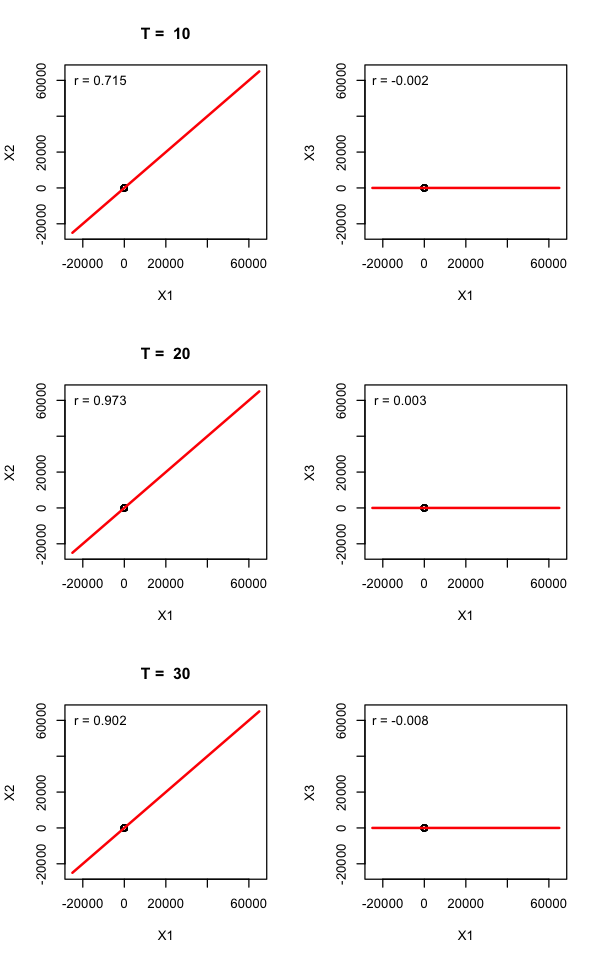

In [55]:
options(repr.plot.width=5, repr.plot.height=8)
par(mfrow=c(3,2))

bounds <- c(-25000, 65000)

T <- 10; T <- which(T_test==T)
plot(sens1[[T]], sens2[[T]], xlim=bounds, ylim=bounds, xlab='X1', ylab='X2')
lines(bounds, bounds, col='red', lwd=2)
text(bounds[1]+0.15*diff(bounds), bounds[1]+0.95*diff(bounds), paste('r = ',round(corr_s12[T],3), sep=''))
title(paste('T = ',T_test[T]))
plot(sens1[[T]], sens3[[T]], xlim=bounds, ylim=bounds, xlab='X1', ylab='X3')
lines(bounds, c(0,0), col='red', lwd=2)
text(bounds[1]+0.15*diff(bounds), bounds[1]+0.95*diff(bounds), paste('r = ',round(corr_s13[T],3), sep=''))

T <- 20; T <- which(T_test==T)
plot(sens1[[T]], sens2[[T]], xlim=bounds, ylim=bounds, xlab='X1', ylab='X2')
lines(bounds, bounds, col='red', lwd=2)
text(bounds[1]+0.15*diff(bounds), bounds[1]+0.95*diff(bounds), paste('r = ',round(corr_s12[T],3), sep=''))
title(paste('T = ',T_test[T]))
plot(sens1[[T]], sens3[[T]], xlim=bounds, ylim=bounds, xlab='X1', ylab='X3')
lines(bounds, c(0,0), col='red', lwd=2)
text(bounds[1]+0.15*diff(bounds), bounds[1]+0.95*diff(bounds), paste('r = ',round(corr_s13[T],3), sep=''))

T <- 30; T <- which(T_test==T)
plot(sens1[[T]], sens2[[T]], xlim=bounds, ylim=bounds, xlab='X1', ylab='X2')
lines(bounds, bounds, col='red', lwd=2)
text(bounds[1]+0.15*diff(bounds), bounds[1]+0.95*diff(bounds), paste('r = ',round(corr_s12[T],3), sep=''))
title(paste('T = ',T_test[T]))
plot(sens1[[T]], sens3[[T]], xlim=bounds, ylim=bounds, xlab='X1', ylab='X3')
lines(bounds, c(0,0), col='red', lwd=2)
text(bounds[1]+0.15*diff(bounds), bounds[1]+0.95*diff(bounds), paste('r = ',round(corr_s13[T],3), sep=''))

In [56]:
corrs <- matrix(nrow=nT, ncol=3)
colnames(corrs) <- c('T','r12','r13')
for (t in 1:nT) {
    corrs[t,] <- c(T_test[t], corr_s12[[t]], corr_s13[[t]])
}

corrs

T,r12,r13
2,0.3378205,0.0519778676
5,0.5981592,-0.0020862559
10,0.7147125,-0.0017227681
15,0.8722230,0.0004203476
20,0.9734583,0.0025164902
25,0.9370186,0.0141434442
30,0.9017960,-0.0077131700
35,0.9289575,-0.0106352645
40,0.9332434,-0.0152332460
45,0.9401995,-0.0132755461


---
## Running many iterations and taking the mean

The `sobol_corr_1.RData` file is from running 10 iterations of this process remotely. Here, we analyze the results.

In [59]:
load('../output/sobol_corr_1.RData')

corr_s12_avg <- apply(corr_s12, 2, median)
corr_s13_avg <- apply(corr_s13, 2, median)

n_iter <- nrow(corr_s12)

Plot of all 100 iterations of this experiment.
* At left: correlation between ensembles $X_1$ and $X_2$, which should become close to 1 as we add in variations in more significant parameters
* At right: correlation between ensembles $X_1$ and $X_3$, which should become close to 0 as we remove more significant parameters

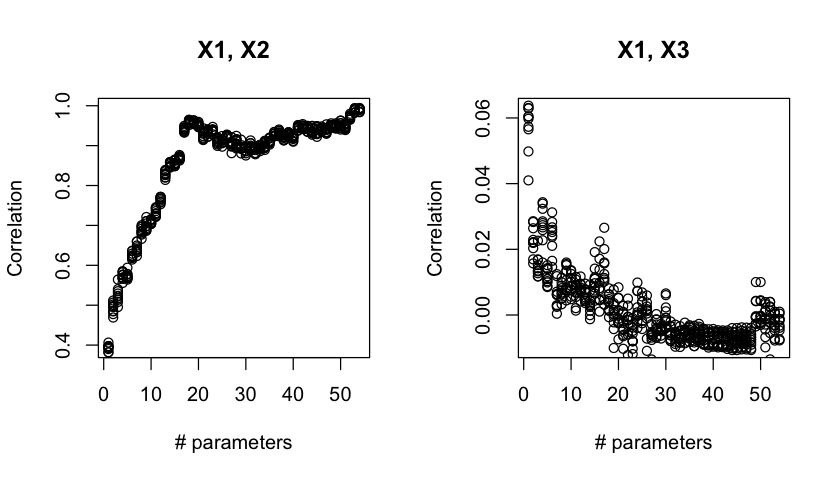

In [60]:
options(repr.plot.width=7, repr.plot.height=4)
par(mfrow=c(1,2))
plot(corr_s12[1,], xlab='# parameters', ylab='Correlation', main='X1, X2'); for (i in 2:n_iter) {points(corr_s12[i,])}
plot(corr_s13[1,], xlab='# parameters', ylab='Correlation', main='X1, X3'); for (i in 2:n_iter) {points(corr_s13[i,])}

Find out where $\texttt{corr}(X_1, X_3)$ becomes less than 0.05, and where $\texttt{corr}(X_1,X_2)$ becomes greater than 0.9

In [70]:
t13 <- which(corr_s13_avg < 0.05)
print(t13)

 [1]  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
[26] 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
[51] 52 53 54


In [71]:
t12 <- which(corr_s12_avg > 0.9)
print(t12)

 [1] 17 18 19 20 21 22 23 24 25 26 27 28 34 35 36 37 38 39 40 41 42 43 44 45 46
[26] 47 48 49 50 51 52 53 54


In case anyone is interested to see which parameters added have most impact.

* `deltaT2X` is the very first parameter, so it is in every set.
* Then when `T_test=2`, we have added `LIFE` for 2 parameters total.
* Then when `T_test=3`, we add `kwcy`, so 3 parameters total.
* And so on...

In [66]:
parnames_added <- rev(parnames_calib[order(s.out$T[,1])])
cbind(parnames_added[2:55], T_test, corr_s12_max, corr_s13_avg)

,T_test,corr_s12_max,corr_s13_avg
ACT,2,0.406381081293545,0.0600748588478277
deltaT2X,3,0.511753358692977,0.022114688593249
Rv_570,4,0.564150922219332,0.013871339769317
exp_fD,5,0.585385131133141,0.027666348256482
Fob,6,0.594073955413466,0.0109624044262891
Ws,7,0.636454412812905,0.0247267756279625
Fmc_0,8,0.659777901732002,0.00618660467135455
FERT,9,0.700412414969444,0.0071694773871829
NV,10,0.721087910869996,0.0119766854480578
Rg_570,11,0.715712449623623,0.00951918098913679


Find the lowest number of parameters to include that satisfies both constraints

In [ ]:
for (t in T_test) {
    
}